# Forward Model Example

In this workbook we will demonstrate the forward modelling capabilities of the ```mmode_tools``` package. We will show the user how to take an example radio interferometer model, along with its beam fringe coefficients (it is assumed that these are generated beforehand) and a model image to the mmode domain. We will then demonstrate the solving the resulting mmode visibilities and the resulting dirty map. 

In [1]:
from mmode_tools.io import get_config_directory
from mmode_tools.io import load_beam_fringe_coef
from mmode_tools.examples import load_example_interferometer,load_model_map
from mmode_tools.modelling import forward_model_mmode_vis
from mmode_tools.utils import data2map
import os
import numpy as np

/Users/coo426/Documents/mmode-tools/.mmode_tools/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Loading in the model map and the interferometer mode.

We also assume some specific parameters such as the frequency, and the max l-degree.

In [2]:
freq = 150e6
lMax = 130
modelMap = load_model_map(freq=freq)
interferometer = load_example_interferometer()

/Users/coo426/Documents/mmode-tools/src/mmode_tools/interferometers.py:613: UserWarning: No longitude provided, assuming 0 [deg].
  warnings.warn("No longitude provided, assuming 0 [deg].")


### Loading in the beam fringe coefficients

In [3]:
# Getting the beam fringe coefficient path.
beamFringePath = get_config_directory(pathName="beamFringePath")

name = interferometer.telescope # Instrument
freqMHz = int(freq/1e6) # Frequency in MHz
# This should be the standard naming convention.
beamFileName = f"beam_fringe_coeffs-{name}-{freqMHz}MHz-I-lMax{lMax}.hdf5"

# The total path to the beam fringe coefficients. 
beamFringeFilePath = beamFringePath + beamFileName

if not os.path.exists(beamFringeFilePath):
    # If the coefficients don't exist, we can make them from scratch.
    from mmode_tools.beam import bline2alm
    from mmode_tools.examples import load_default_beam_model
    beamModel = load_default_beam_model(LAT=interferometer.lat,
                                        lMax=lMax,freq=freq,pol='I')
    blines,antPairs = interferometer.get_baselines(interferometer)
    blmCoeffTensor = bline2alm(blines,beamModel,freq,interferometer.lat,lMax)
    blmCoeffTensor = blmCoeffTensor[:,0,:,:] # Only need the positive mmodes.
else:
    # Otherwise we simply load them into existence. 
    blmCoeffTensor = load_beam_fringe_coef(beamFringeFilePath,lmax=lMax,
                                           verbose=True)



lmax= 130
CoeffTensor.shape = (992, 131, 131)
CoeffTensor size = 0.127 GB
Dataset size = 0.127 GB


### Next we estimate the mmode visibilities by forward modelling the model map with the beam fringe coefficients.

In [4]:
mmodeTensor = forward_model_mmode_vis(modelMap,blmCoeffTensor,lMax=lMax)

## Making the Dirty Map

Finally we can test the mmode visibilities by inverting them with the beam fringe coefficients of our instrument. To make a more realistic dirty image, you could add noise to the mmode visibilities, for simplicity we do not. 

The inversion is a simple Tikhonov regularisation, where the damping coefficient $\lambda=0.01$ is set to a reasonably good default value. For real instruments the optimal damping coefficient requires find the trade off between the amplitude of the resulting fit coefficients and the residuals. See Eastwood et al. (2018) and Kriele et al. (2022) for more details on this process. We leave the determination of the optimal parameters as an exercise for the user.

### Weighting
The current version of the regularisation requires an input weight vector, which corresponds to the diagonal terms of the Weight matrix (which has a size equal to the number of visibilities). For this data the weights should be 1. For real data, the noise amplitudes for each visibility are good measure and help with the inversion. 

It is also possible to use other weighting schemes such as uniform weighting (weights of 1 is equal to natural) like in traditional interferometric imaging. The uniform based weights can be calculated by first gridding the $(u,v)$ points onto the $uv$-plane. The resulting weights for each cell then correspond to each of the input visibilities. These can then be used as the diagonal entries in the weights array. Likewise, this could be done using a Guassian weightin scheme as well.

In [5]:
damp = 0.01
weights = np.ones(mmodeTensor.shape[0]) # Weights could be the noise amplitude.
dirtyMap,dirtyCoeffs = data2map(np.conj(mmodeTensor),[np.conj(blmCoeffTensor)],
                                weights,returnCoeffs=True,lMax=lMax,damp=damp)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 112 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 127 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 131 out of 131 | elapsed:    0.4s finished


### Plotting the results

Here we show the dirty sky SH coefficients, and the diry map. For completeness we also plot the imaginary values.

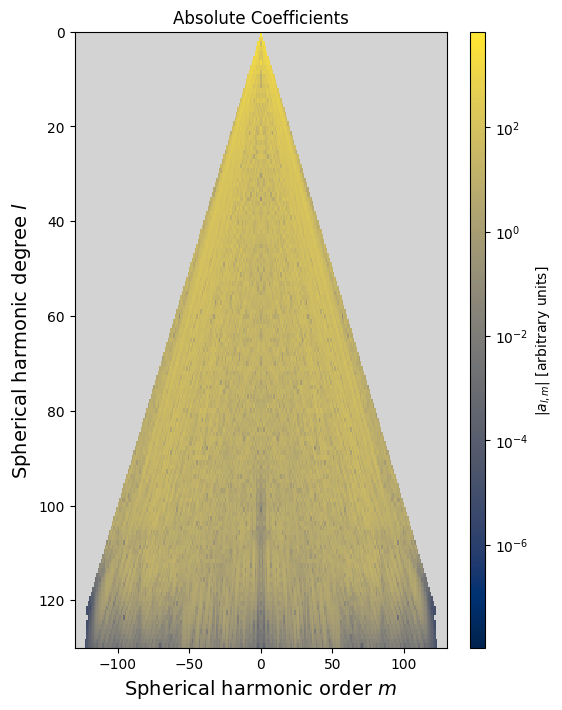

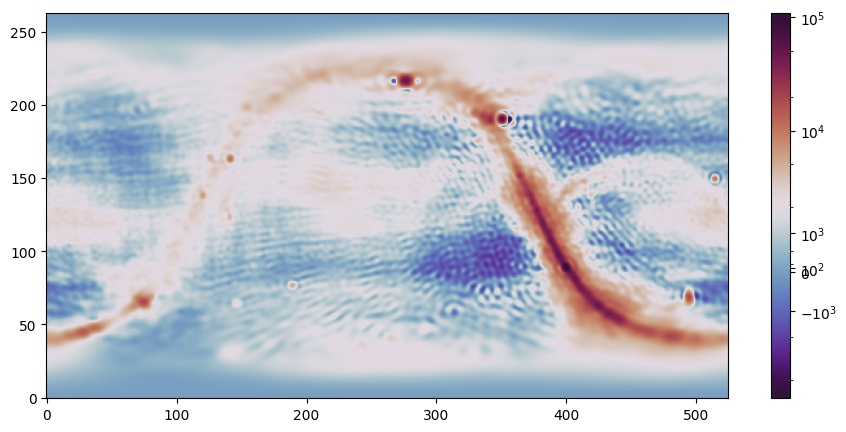

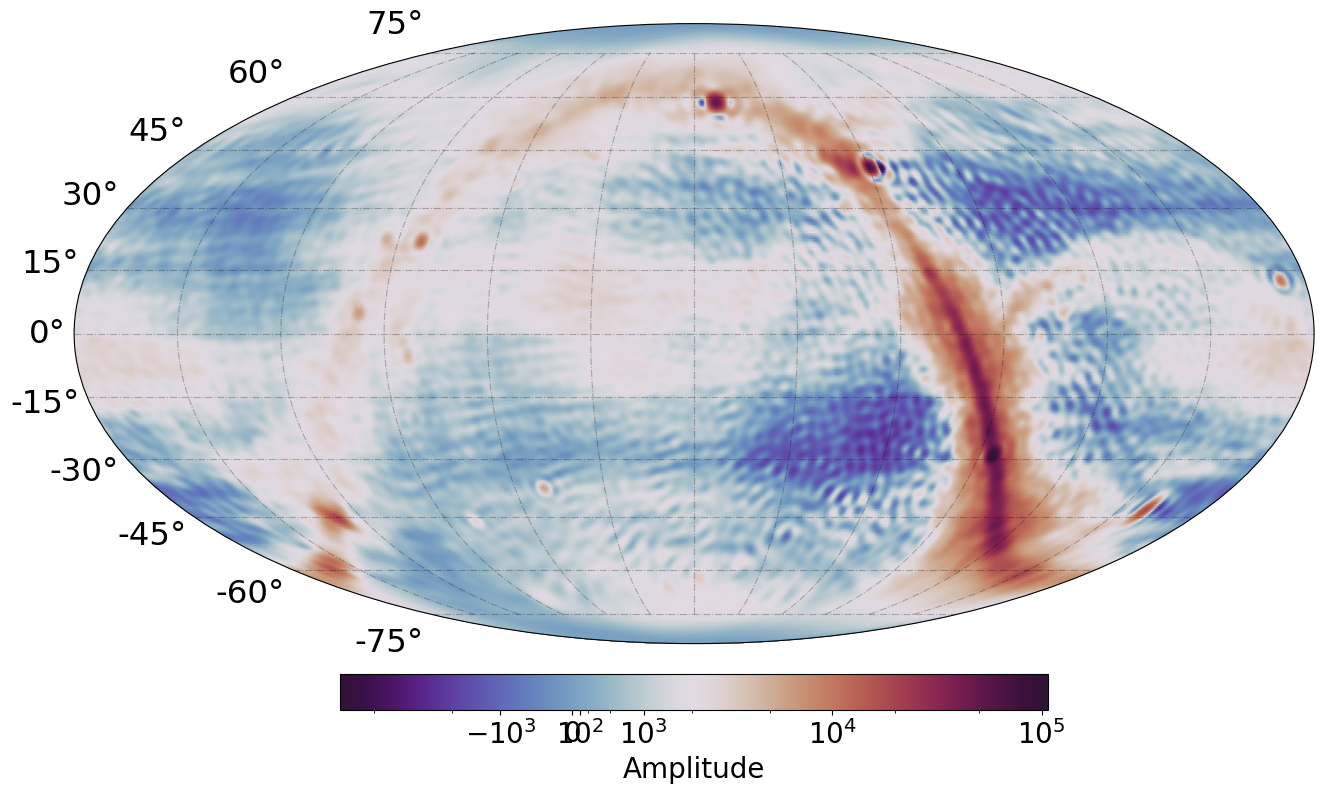

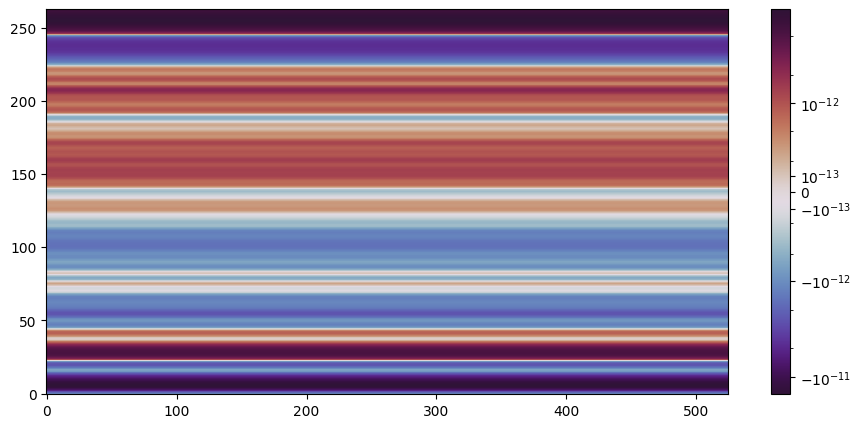

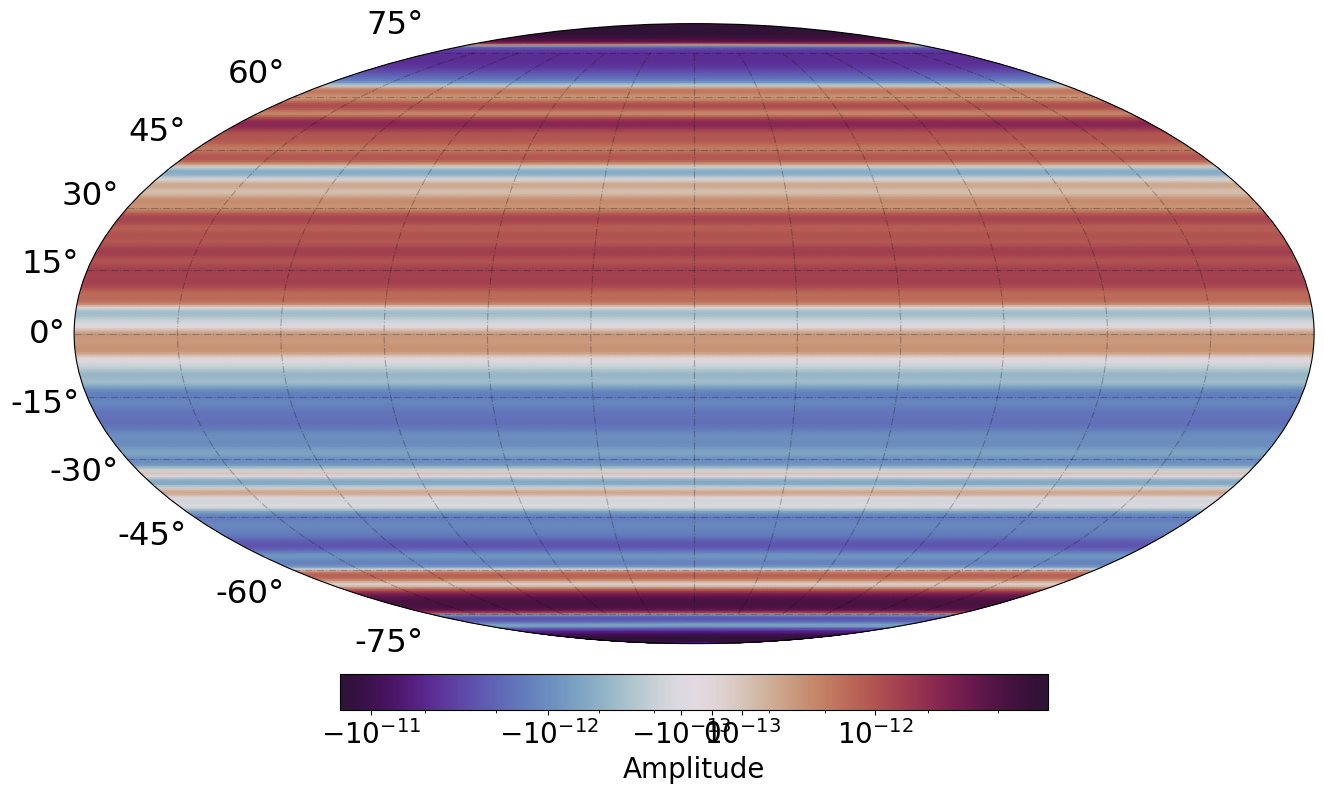

In [6]:
from mmode_tools.clean import plot_dirty_image
from mmode_tools.plots import coefficient_plot,plot_equatorial_map

#
coefficient_plot(dirtyCoeffs,norm='log',cmap='cividis',interpolation='None')

#
plot_dirty_image(dirtyMap.real,norm='asinh')
plot_equatorial_map(dirtyMap.real,norm='asinh')

#
plot_dirty_image(dirtyMap.imag,norm='asinh')
plot_equatorial_map(dirtyMap.imag,norm='asinh')
